# Data Collection Pipeline V4 - Pareto Top-N Approach

## Two-Phase Approach:

### Phase 1: Build Cost Pool
- Generate random cost parameters
- Optimize each with ODL API
- Store (costs, features) pairs
- Can skip if you already have cost_pool.json

### Phase 2: Match Preferences (New!)
- Generate random preferences
- Get **top 30 solutions** from pool (closest to ideal)
- Use **Pareto evaluation** to select best
- Save training samples

## Benefits:
- ✅ 30 unique outputs (vs 5-7 with old method)
- ✅ High quality (top 15% of solutions)
- ✅ No arbitrary scaling factors
- ✅ Ready for regression training

## 1. Imports

In [11]:
import json
import time
import requests
import numpy as np
import pandas as pd
from datetime import datetime
from pathlib import Path
import copy
from typing import List, Dict

print("✓ Imports successful")

✓ Imports successful


## 2. Configuration

**⚠️ UPDATE THESE VALUES:**

In [35]:
# API Configuration


# Model file (use relaxed version without skill requirements)
MODEL_PATH = "../../test_model_mathias_fixed.json"  # ← CHANGE THIS

# Phase 1: Cost Pool Generation
POOL_SIZE = 200  # Number of cost sets to generate
WAIT_SECONDS = 30  # Wait time for optimization (can be 30-120s)
CHECKPOINT_EVERY = 10  # Save progress every N samples
POOL_FILE = "cost_pool.json"  # Output file

# Phase 2: Training Data Generation  
N_SAMPLES = 400  # Number of training samples to generate
TOP_N = 100  # Use top N solutions from pool (30 = good diversity)
TOP_K = 3  # Use top K solutions to form Pareto front (30 = good diversity)
OUTPUT_FILE = "N=100(more-random).json"  # Output file

# Cost parameter ranges
COST_RANGES = {
    'costPerTravelHour': (0.5, 5.0),
    'costPerKm': (0.01, 0.5),
    'parking_multiplier': (0.2, 2.0)
}

print(f"Configuration loaded:")
print(f"  Pool size: {POOL_SIZE}")
print(f"  Training samples: {N_SAMPLES}")
print(f"  Top-N selection: {TOP_N}")
print(f"  Estimated Phase 1 time: {(POOL_SIZE * WAIT_SECONDS) / 3600:.1f} hours")

Configuration loaded:
  Pool size: 200
  Training samples: 400
  Top-N selection: 100
  Estimated Phase 1 time: 1.7 hours


## 3. Pareto Analyzer Class

In [36]:
class ParetoAnalyzer:
    """Top-N + Pareto selection for cost pool matching"""
    
    def __init__(self, cost_pool: List[Dict]):
        self.cost_pool = cost_pool
        self.objectives = ['avg_parking_difficulty', 'total_travel_hours', 'total_distance_km']
    
    def get_top_n_solutions(self, n=30) -> List[Dict]:
        """
        Get top N solutions by distance to ideal point (0,0,0)
        
        These are the N "best" solutions overall, regardless of preferences.
        """
        if len(self.cost_pool) == 0:
            return []
        
        # Extract features for all solutions
        all_features = np.array([[s['features'][obj] for obj in self.objectives] 
                                for s in self.cost_pool])
        
        # Normalize to [0, 1] range
        min_vals = all_features.min(axis=0)
        max_vals = all_features.max(axis=0)
        normalized = (all_features - min_vals) / (max_vals - min_vals + 1e-10)
        
        # Calculate distance to ideal point (0,0,0)
        distances = np.sqrt(np.sum(normalized**2, axis=1))
        
        # Select top N by lowest distance
        n = min(n, len(self.cost_pool))  # Don't exceed pool size
        best_indices = np.argsort(distances)[:n]
        
        return [self.cost_pool[i] for i in best_indices]
    
    def normalize_objectives(self, solutions: List[Dict]) -> np.ndarray:
        """Normalize objectives to [0, 1] for fair comparison"""
        if len(solutions) == 0:
            return np.array([])
        
        values = np.array([[s['features'][obj] for obj in self.objectives] 
                          for s in solutions])
        
        normalized = np.zeros_like(values, dtype=float)
        for j in range(len(self.objectives)):
            min_val = values[:, j].min()
            max_val = values[:, j].max()
            if max_val > min_val:
                normalized[:, j] = (values[:, j] - min_val) / (max_val - min_val)
            else:
                normalized[:, j] = 0.0
        
        return normalized
    
    def select_best(self, solutions: List[Dict], preferences: Dict) -> Dict:
        """
        Select best solution from list using weighted Euclidean distance
        
        Args:
            solutions: List of candidate solutions
            preferences: User preference weights
        
        Returns:
            Best matching solution (copy with added metadata)
        """
        if len(solutions) == 0:
            return None
        
        if len(solutions) == 1:
            result = solutions[0].copy()
            result['pareto_distance'] = 0.0
            result['selection_pool_size'] = 1
            return result
        
        # Normalize objectives
        normalized = self.normalize_objectives(solutions)
        
        # Create weight vector from preferences
        weights = np.array([
            preferences['parking_importance'],
            preferences['time_importance'],
            preferences['distance_importance']
        ])
        
        # Calculate weighted Euclidean distance to ideal (0,0,0)
        distances = np.sqrt(np.sum((normalized * weights) ** 2, axis=1))
        
        # Select solution with minimum distance
        best_idx = np.argmin(distances)
        
        # Return copy with metadata
        result = solutions[best_idx].copy()
        result['pareto_distance'] = float(distances[best_idx])
        result['selection_pool_size'] = len(solutions)
        
        return result

print("✓ ParetoAnalyzer class defined")

✓ ParetoAnalyzer class defined


## 4. Data Collector Class

In [37]:
class CostPoolDataCollector:
    """Two-phase data collector with Pareto Top-N selection"""
    
    def __init__(self, base_url, username, password, model_path, cost_ranges):
        self.base_url = base_url.rstrip('/')
        self.username = username
        self.password = password
        self.cost_ranges = cost_ranges
        
        # Initialize session
        self.session = requests.Session()
        self.session.auth = (username, password)
        self.session.headers.update({
            'Content-Type': 'application/json',
            'Accept': 'application/json'
        })
        
        # Load base model
        with open(model_path, 'r') as f:
            self.base_model = json.load(f)
        
        print(f"✓ Initialized")
        print(f"  Jobs: {len(self.base_model['data']['jobs'])}")
        print(f"  Vehicles: {len(self.base_model['data']['vehicles'])}")
        
        # Data storage
        self.cost_pool = []
        self.training_data = []
    
    # ========================================================================
    # HELPER METHODS
    # ========================================================================
    
    def sample_random_costs(self):
        """Sample random cost parameters"""
        costs = {}
        for param, (min_val, max_val) in self.cost_ranges.items():
            costs[param] = np.random.uniform(min_val, max_val)
        
        # Round for cleaner values
        costs['costPerTravelHour'] = round(costs['costPerTravelHour'], 2)
        costs['costPerKm'] = round(costs['costPerKm'], 4)
        costs['parking_multiplier'] = round(costs['parking_multiplier'], 2)
        
        return costs
    
    # def sample_preferences(self):
    #     """Sample random preferences using Dirichlet distribution"""
    #     # Dirichlet ensures diversity and sum close to ~3
    #     weights = np.random.dirichlet([1, 1, 1])
    #     return {
    #         'parking_importance': float(weights[0]),
    #         'time_importance': float(weights[1]),
    #         'distance_importance': float(weights[2])
    #     }
    
    def sample_preferences(self):
        """Sample with more extreme preferences"""
        import random
        
        # 50% extreme preferences, 50% balanced
        if random.random() < 0.5:
            # Extreme: one dimension dominates
            choice = random.randint(0, 2)
            weights = [0.1, 0.1, 0.1]
            weights[choice] = 0.8
            
            return {
                'parking_importance': weights[0],
                'time_importance': weights[1],
                'distance_importance': weights[2]
            }
        else:
            # Balanced: use Dirichlet
            weights = np.random.dirichlet([1, 1, 1])
            return {
                'parking_importance': float(weights[0]),
                'time_importance': float(weights[1]),
                'distance_importance': float(weights[2])
            }
    
    def apply_costs_to_model(self, costs):
        """Apply cost parameters to model"""
        model = copy.deepcopy(self.base_model)
        
        # Apply vehicle costs
        for vehicle in model['data']['vehicles']:
            if 'definition' in vehicle:
                vehicle['definition']['costPerTravelHour'] = costs['costPerTravelHour']
                vehicle['definition']['costPerKm'] = costs['costPerKm']
        
        # Apply parking multiplier to delivery stops
        for job in model['data']['jobs']:
            for stop in job.get('stops', []):
                if (stop.get('type') == 'SHIPMENT_DELIVERY' and 
                    'parking' in stop and 
                    'cost' in stop['parking'] and 
                    stop['parking']['cost'] > 0):
                    original_cost = stop['parking']['cost']
                    stop['parking']['cost'] = original_cost * costs['parking_multiplier']
        
        return model
    
    def send_to_odl(self, model, model_id):
        """Send model to ODL API"""
        url = f"{self.base_url}/models/{model_id}"
        try:
            response = self.session.put(url, json=model, timeout=30)
            response.raise_for_status()
            return True
        except Exception as e:
            print(f"  ✗ Upload failed: {e}")
            return False
    
    def get_plan(self, model_id):
        """Retrieve plan from ODL API"""
        url = f"{self.base_url}/models/{model_id}/optimiserstate/plan"
        try:
            response = self.session.get(url, timeout=30)
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"  ✗ Get plan failed: {e}")
            return None
    
    def extract_features(self, plan):
        """Extract route features from plan"""
        if not plan or 'vehiclePlans' not in plan:
            return None
        
        features = {
            'total_distance_km': 0.0,
            'total_travel_hours': 0.0,
            'total_cost': 0.0,
            'num_stops': 0,
            'num_vehicles_used': 0,
            'unplanned_jobs': len(plan.get('unplannedJobs', [])),
            'avg_parking_difficulty': 0.0
        }
        
        total_parking_cost = 0.0
        total_stops = 0
        
        for vehicle_plan in plan['vehiclePlans']:
            stops = vehicle_plan.get('plannedStops', [])
            
            if len(stops) > 0:
                features['num_vehicles_used'] += 1
                features['num_stops'] += len(stops)
                total_stops += len(stops)
            
            time_stats = vehicle_plan.get('timeStatistics', {})
            features['total_distance_km'] += time_stats.get('travelMetres', 0) / 1000.0
            features['total_travel_hours'] += time_stats.get('travelSeconds', 0) / 3600.0
            features['total_cost'] += time_stats.get('cost', 0)
            
            breakdown = time_stats.get('optimiserCostBreakdown', {})
            total_parking_cost += breakdown.get('PARKING_COST', 0.0)
        
        if total_stops > 0:
            features['avg_parking_difficulty'] = total_parking_cost / total_stops
        
        # Round
        features['total_distance_km'] = round(features['total_distance_km'], 2)
        features['total_travel_hours'] = round(features['total_travel_hours'], 2)
        features['total_cost'] = round(features['total_cost'], 2)
        features['avg_parking_difficulty'] = round(features['avg_parking_difficulty'], 2)
        
        return features
    
    # ========================================================================
    # PHASE 1: BUILD COST POOL
    # ========================================================================
    
    def build_cost_pool(self, pool_size, wait_seconds, checkpoint_every, pool_file):
        """Phase 1: Generate pool of cost sets with optimized solutions"""
        print(f"\n{'='*60}")
        print(f"PHASE 1: BUILDING COST POOL")
        print(f"{'='*60}")
        print(f"Target: {pool_size} cost sets")
        print(f"Estimated time: {(pool_size * wait_seconds) / 3600:.1f} hours")
        print(f"{'='*60}\n")
        
        start_time = time.time()
        
        try:
            for i in range(1, pool_size + 1):
                print(f"\nCost Set {i}/{pool_size}:")
                
                try:
                    costs = self.sample_random_costs()
                    print(f"  Costs: {costs['costPerTravelHour']:.2f}/h, "
                          f"{costs['costPerKm']:.4f}/km, parking×{costs['parking_multiplier']:.2f}")
                    
                    model = self.apply_costs_to_model(costs)
                    model_id = f"cost_pool_{i}"
                    
                    if not self.send_to_odl(model, model_id):
                        continue
                    
                    print(f"  ✓ Uploaded, waiting {wait_seconds}s...")
                    time.sleep(wait_seconds)
                    
                    plan = self.get_plan(model_id)
                    features = self.extract_features(plan)
                    
                    if features is None:
                        print(f"  ✗ Failed to extract features")
                        continue
                    
                    print(f"  Features: {features['total_distance_km']:.1f}km, "
                          f"{features['total_travel_hours']:.1f}h, "
                          f"parking={features['avg_parking_difficulty']:.1f}, "
                          f"unplanned={features['unplanned_jobs']}")
                    
                    self.cost_pool.append({
                        'pool_id': i,
                        'costs': costs,
                        'features': features,
                        'timestamp': datetime.now().isoformat()
                    })
                    
                    print(f"  ✓ Added (total: {len(self.cost_pool)})")
                    
                    if i % checkpoint_every == 0:
                        self.save_cost_pool(pool_file)
                        elapsed = time.time() - start_time
                        remaining = ((pool_size - i) * elapsed / i)
                        print(f"\n  CHECKPOINT: {len(self.cost_pool)}/{pool_size} | "
                              f"Elapsed: {elapsed/3600:.1f}h | Remaining: {remaining/3600:.1f}h\n")
                
                except Exception as e:
                    print(f"  ✗ Error: {e}")
        
        except KeyboardInterrupt:
            print(f"\n\nInterrupted! Pool has {len(self.cost_pool)} entries")
        
        self.save_cost_pool(pool_file)
        
        elapsed = time.time() - start_time
        print(f"\n{'='*60}")
        print(f"PHASE 1 COMPLETE")
        print(f"{'='*60}")
        print(f"Cost pool: {len(self.cost_pool)} solutions")
        print(f"Time: {elapsed/3600:.1f} hours")
        print(f"Saved to: {pool_file}")
        print(f"{'='*60}\n")
    
    def save_cost_pool(self, pool_file):
        """Save cost pool to file"""
        with open(pool_file, 'w') as f:
            json.dump(self.cost_pool, f, indent=2)
        print(f"  💾 Saved to {pool_file}")
    
    def load_cost_pool(self, pool_file):
        """Load cost pool from file"""
        try:
            with open(pool_file, 'r') as f:
                self.cost_pool = json.load(f)
            print(f"✓ Loaded {len(self.cost_pool)} solutions from {pool_file}")
            return True
        except FileNotFoundError:
            print(f"✗ File not found: {pool_file}")
            return False
    
    # ========================================================================
    # PHASE 2: MATCH PREFERENCES TO POOL (PARETO TOP-N)
    # ========================================================================
    
    def find_best_match(self, preferences, top_n=30):
        """
        Find best match using Pareto Top-N selection
        
        Process:
        1. Get top N solutions (closest to ideal point)
        2. Select best using weighted Pareto evaluation
        """
        if len(self.cost_pool) == 0:
            return None
        
        analyzer = ParetoAnalyzer(self.cost_pool)
        top_solutions = analyzer.get_top_n_solutions(n=top_n)
        best_match = analyzer.select_best(top_solutions, preferences)
        
        return best_match
    
    def generate_training_samples(self, n_samples, top_n, top_k, output_file):
        """Phase 2: Generate training samples using top-K matches per preference"""
        if len(self.cost_pool) == 0:
            print("✗ Cost pool is empty! Load or build first.")
            return
        
        print(f"\n{'='*60}")
        print(f"PHASE 2: GENERATING TRAINING SAMPLES")
        print(f"{'='*60}")
        print(f"Cost pool: {len(self.cost_pool)} solutions")
        print(f"Preferences: {n_samples}")
        print(f"Top-N selection: {top_n}")
        print(f"Top-K per preference: {top_k}")
        print(f"Total samples: {n_samples * top_k}")
        print(f"{'='*60}\n")
        
        self.training_data = []
        analyzer = ParetoAnalyzer(self.cost_pool)
        
        for i in range(1, n_samples + 1):
            print(f"\rPreference {i}/{n_samples}", end='', flush=True)
            
            preferences = self.sample_preferences()
            top_solutions = analyzer.get_top_n_solutions(n=top_n)
            
            # Calculate distances for all top N
            normalized = analyzer.normalize_objectives(top_solutions)
            weights = np.array([
                preferences['parking_importance'],
                preferences['time_importance'],
                preferences['distance_importance']
            ])
            distances = np.sqrt(np.sum((normalized * weights) ** 2, axis=1))
            
            # Get top K matches (not just best 1!)
            top_k_indices = np.argsort(distances)[:top_k]
            
            # Create K samples from same preference
            for rank, idx in enumerate(top_k_indices, 1):
                solution = top_solutions[idx]
                
                sample = {
                    'sample_id': len(self.training_data) + 1,
                    'preferences': preferences,
                    'costs': solution['costs'],
                    'features': solution['features'],
                    'metadata': {
                        'pool_id': solution['pool_id'],
                        'rank_for_preference': rank,
                        'pareto_distance': float(distances[idx]),
                        'selection_pool_size': top_n,
                        'timestamp': datetime.now().isoformat()
                    }
                }
                
                self.training_data.append(sample)
        
        # Save
        with open(output_file, 'w') as f:
            json.dump(self.training_data, f, indent=2)
        
        print(f"\n\n{'='*60}")
        print(f"PHASE 2 COMPLETE")
        print(f"{'='*60}")
        print(f"Generated: {len(self.training_data)} samples")
        print(f"From: {n_samples} preferences × top-{top_k}")
        print(f"Saved to: {output_file}")
        
        # Statistics
        pool_ids = [s['metadata']['pool_id'] for s in self.training_data]
        unique_ids = len(set(pool_ids))
        print(f"\nDiversity: {unique_ids} unique solutions used")
        print(f"Avg samples per solution: {len(self.training_data) / unique_ids:.1f}")
        print(f"{'='*60}\n")

print("✓ CostPoolDataCollector class defined")

✓ CostPoolDataCollector class defined


## 5. Initialize Collector

In [38]:
collector = CostPoolDataCollector(
    base_url=BASE_URL,
    username=USERNAME,
    password=PASSWORD,
    model_path=MODEL_PATH,
    cost_ranges=COST_RANGES
)

✓ Initialized
  Jobs: 106
  Vehicles: 26


## 6. Phase 1: Build Cost Pool (or Load Existing)

**If you already have cost_pool.json, skip to Phase 2!**

In [39]:
# Option A: Load existing pool
collector.load_cost_pool(POOL_FILE)

✓ Loaded 200 solutions from cost_pool.json


True

In [ ]:
# Option B: Build new pool (takes ~6 hours for 200 samples at 30s each)
collector.build_cost_pool(
    pool_size=POOL_SIZE,
    wait_seconds=WAIT_SECONDS,
    checkpoint_every=CHECKPOINT_EVERY,
    pool_file=POOL_FILE
)

## 7. Analyze Cost Pool (Optional)

In [40]:
# Quick analysis
if len(collector.cost_pool) > 0:
    analyzer = ParetoAnalyzer(collector.cost_pool)
    top_30 = analyzer.get_top_n_solutions(n=30)
    
    print(f"Cost pool analysis:")
    print(f"  Total solutions: {len(collector.cost_pool)}")
    print(f"  Top 30 solutions: {len(top_30)}")
    print(f"  Top 30 = top {100*len(top_30)/len(collector.cost_pool):.1f}%")
    
    # Check unplanned jobs
    unplanned = [s['features']['unplanned_jobs'] for s in collector.cost_pool]
    print(f"\n  Unplanned jobs: min={min(unplanned)}, max={max(unplanned)}, avg={np.mean(unplanned):.1f}")
    if max(unplanned) > 5:
        print(f"  ⚠️  Consider using relaxed model (remove skill requirements)")

Cost pool analysis:
  Total solutions: 200
  Top 30 solutions: 30
  Top 30 = top 15.0%

  Unplanned jobs: min=20, max=20, avg=20.0
  ⚠️  Consider using relaxed model (remove skill requirements)


## 8. Phase 2: Generate Training Samples

In [41]:
collector.generate_training_samples(
    n_samples=N_SAMPLES,
    top_n=TOP_N,
    top_k=TOP_K,  # ← Add this parameter
    output_file=OUTPUT_FILE
)


PHASE 2: GENERATING TRAINING SAMPLES
Cost pool: 200 solutions
Preferences: 400
Top-N selection: 100
Top-K per preference: 3
Total samples: 1200

Preference 400/400

PHASE 2 COMPLETE
Generated: 1200 samples
From: 400 preferences × top-3
Saved to: N=100(more-random).json

Diversity: 13 unique solutions used
Avg samples per solution: 92.3



## 9. View Sample

In [18]:
# Show first training sample
if len(collector.training_data) > 0:
    print(json.dumps(collector.training_data[0], indent=2))

{
  "sample_id": 1,
  "preferences": {
    "parking_importance": 0.04314823087550373,
    "time_importance": 0.28700060829194274,
    "distance_importance": 0.6698511608325536
  },
  "costs": {
    "costPerTravelHour": 1.04,
    "costPerKm": 0.0241,
    "parking_multiplier": 1.48
  },
  "features": {
    "total_distance_km": 992.98,
    "total_travel_hours": 30.23,
    "total_cost": 494286.75,
    "num_stops": 172,
    "num_vehicles_used": 8,
    "unplanned_jobs": 20,
    "avg_parking_difficulty": 309.84
  },
  "metadata": {
    "pool_id": 58,
    "rank_for_preference": 1,
    "pareto_distance": 0.03996298278396572,
    "selection_pool_size": 30,
    "timestamp": "2025-10-29T10:44:21.690797"
  }
}


Cost pool: 200 solutions
Training data: 1200 samples

Pareto front: 7 solutions
Pareto IDs: [4, 23, 25, 57, 58, 134, 173]

Used in training: 13 unique solutions


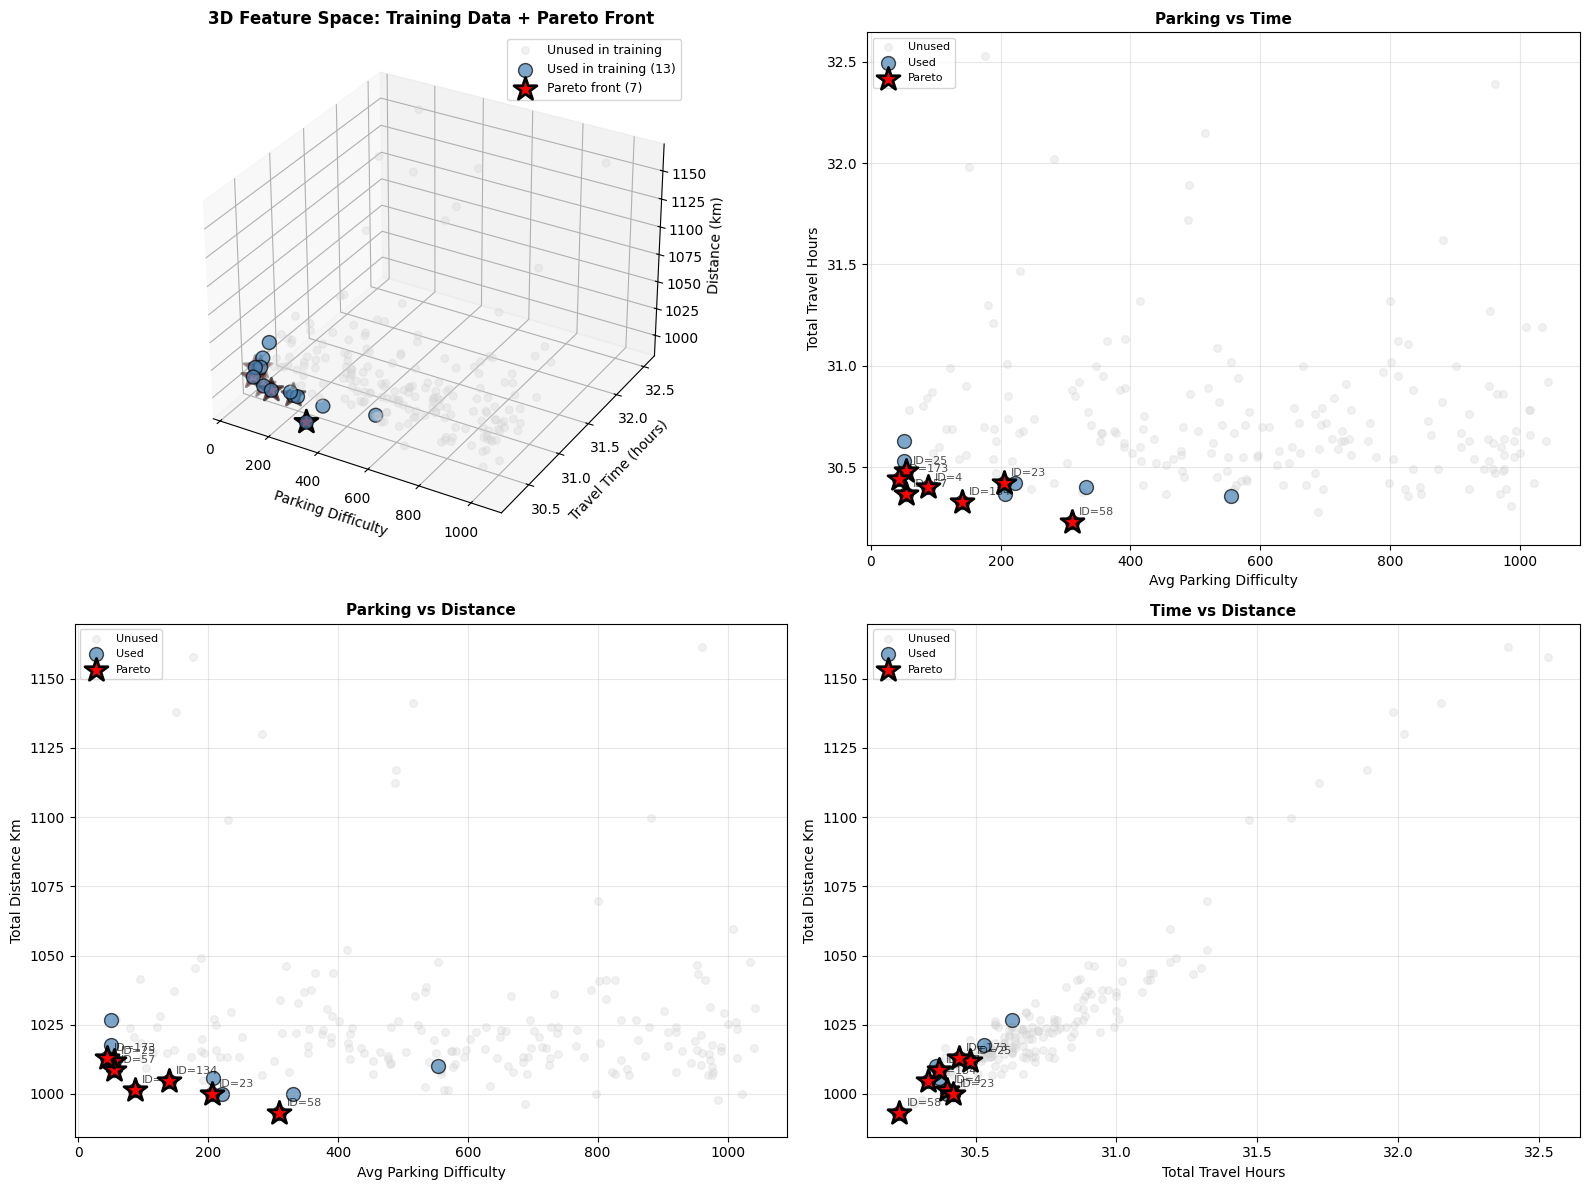


✓ Saved: training_data_pareto_visualization.png


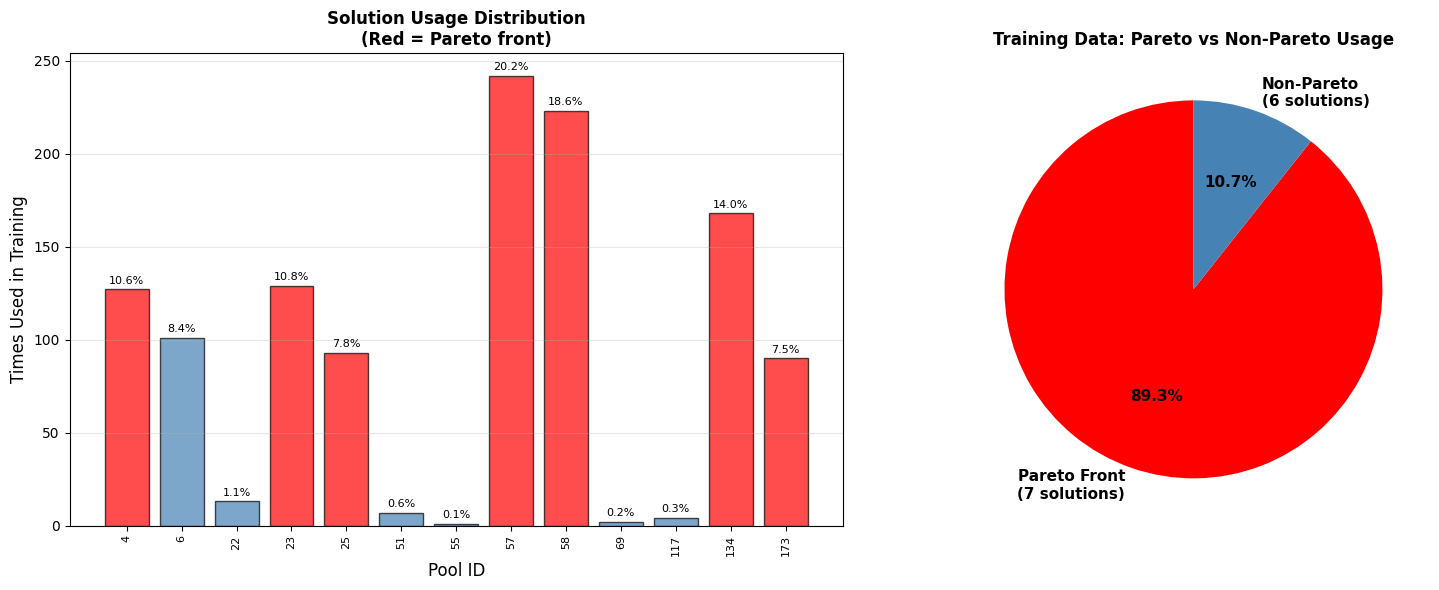

✓ Saved: training_data_usage_analysis.png

SUMMARY STATISTICS

Cost Pool:
  Total solutions: 200
  Pareto front: 7 (3.5%)

Training Data:
  Total samples: 1200
  Unique solutions: 13
  Samples per solution: 92.3

Pareto Front Usage:
  Pareto solutions in training: 7/7
  Pareto samples: 1072/1200 (89.3%)

Top 5 most used solutions:
  pool_id=57: 242 times (20.2%) ⭐ PARETO
  pool_id=58: 223 times (18.6%) ⭐ PARETO
  pool_id=134: 168 times (14.0%) ⭐ PARETO
  pool_id=23: 129 times (10.8%) ⭐ PARETO
  pool_id=4: 127 times (10.6%) ⭐ PARETO



In [43]:
# Paste this into a new notebook cell - Visualize Training Data + Pareto Front

import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Load data
with open('cost_pool.json', 'r') as f:
    cost_pool = json.load(f)

with open(OUTPUT_FILE, 'r') as f:
    training_data = json.load(f)

print(f"Cost pool: {len(cost_pool)} solutions")
print(f"Training data: {len(training_data)} samples")

# Extract features
all_parking = [s['features']['avg_parking_difficulty'] for s in cost_pool]
all_time = [s['features']['total_travel_hours'] for s in cost_pool]
all_distance = [s['features']['total_distance_km'] for s in cost_pool]

# Get pool_ids used in training
training_pool_ids = set([s['metadata']['pool_id'] for s in training_data])

# Separate into used/unused
used_parking = [s['features']['avg_parking_difficulty'] for s in cost_pool if s['pool_id'] in training_pool_ids]
used_time = [s['features']['total_travel_hours'] for s in cost_pool if s['pool_id'] in training_pool_ids]
used_distance = [s['features']['total_distance_km'] for s in cost_pool if s['pool_id'] in training_pool_ids]

unused_parking = [s['features']['avg_parking_difficulty'] for s in cost_pool if s['pool_id'] not in training_pool_ids]
unused_time = [s['features']['total_travel_hours'] for s in cost_pool if s['pool_id'] not in training_pool_ids]
unused_distance = [s['features']['total_distance_km'] for s in cost_pool if s['pool_id'] not in training_pool_ids]

# Find Pareto front
from collections import Counter

class SimpleParetoFinder:
    def dominates(self, a, b):
        better_in_one = False
        for key in ['avg_parking_difficulty', 'total_travel_hours', 'total_distance_km']:
            if a['features'][key] > b['features'][key]:
                return False
            if a['features'][key] < b['features'][key]:
                better_in_one = True
        return better_in_one
    
    def find_pareto_front(self, solutions):
        pareto = []
        for candidate in solutions:
            if not any(self.dominates(other, candidate) 
                      for other in solutions 
                      if other['pool_id'] != candidate['pool_id']):
                pareto.append(candidate)
        return pareto

finder = SimpleParetoFinder()
pareto_front = finder.find_pareto_front(cost_pool)

pareto_parking = [s['features']['avg_parking_difficulty'] for s in pareto_front]
pareto_time = [s['features']['total_travel_hours'] for s in pareto_front]
pareto_distance = [s['features']['total_distance_km'] for s in pareto_front]
pareto_ids = [s['pool_id'] for s in pareto_front]

print(f"\nPareto front: {len(pareto_front)} solutions")
print(f"Pareto IDs: {sorted(pareto_ids)}")
print(f"\nUsed in training: {len(training_pool_ids)} unique solutions")

# =============================================================================
# VISUALIZATION 1: 3D Scatter Plot
# =============================================================================

fig = plt.figure(figsize=(16, 12))

# Plot 1: 3D view
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

# Unused solutions (gray)
ax1.scatter(unused_parking, unused_time, unused_distance, 
           c='lightgray', s=30, alpha=0.3, label='Unused in training')

# Used solutions (blue)
ax1.scatter(used_parking, used_time, used_distance,
           c='steelblue', s=100, alpha=0.7, edgecolors='black', 
           linewidths=1, label=f'Used in training ({len(training_pool_ids)})')

# Pareto front (red stars)
ax1.scatter(pareto_parking, pareto_time, pareto_distance,
           c='red', s=300, marker='*', edgecolors='black',
           linewidths=2, label=f'Pareto front ({len(pareto_front)})', zorder=10)

ax1.set_xlabel('Parking Difficulty', fontsize=10)
ax1.set_ylabel('Travel Time (hours)', fontsize=10)
ax1.set_zlabel('Distance (km)', fontsize=10)
ax1.set_title('3D Feature Space: Training Data + Pareto Front', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)

# =============================================================================
# Plot 2-4: 2D Projections
# =============================================================================

projections = [
    (2, 2, 2, 'avg_parking_difficulty', 'total_travel_hours', 'Parking vs Time'),
    (2, 2, 3, 'avg_parking_difficulty', 'total_distance_km', 'Parking vs Distance'),
    (2, 2, 4, 'total_travel_hours', 'total_distance_km', 'Time vs Distance')
]

for row, col, pos, x_feat, y_feat, title in projections:
    ax = fig.add_subplot(row, col, pos)
    
    # Extract data for this projection
    unused_x = [s['features'][x_feat] for s in cost_pool if s['pool_id'] not in training_pool_ids]
    unused_y = [s['features'][y_feat] for s in cost_pool if s['pool_id'] not in training_pool_ids]
    
    used_x = [s['features'][x_feat] for s in cost_pool if s['pool_id'] in training_pool_ids]
    used_y = [s['features'][y_feat] for s in cost_pool if s['pool_id'] in training_pool_ids]
    
    pareto_x = [s['features'][x_feat] for s in pareto_front]
    pareto_y = [s['features'][y_feat] for s in pareto_front]
    
    # Plot
    ax.scatter(unused_x, unused_y, c='lightgray', s=30, alpha=0.3, label='Unused')
    ax.scatter(used_x, used_y, c='steelblue', s=100, alpha=0.7, 
              edgecolors='black', linewidths=1, label='Used')
    ax.scatter(pareto_x, pareto_y, c='red', s=300, marker='*',
              edgecolors='black', linewidths=2, label='Pareto', zorder=10)
    
    # Add pool_id labels for Pareto points
    for s in pareto_front:
        ax.annotate(f"ID={s['pool_id']}", 
                   (s['features'][x_feat], s['features'][y_feat]),
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=8, alpha=0.7)
    
    ax.set_xlabel(x_feat.replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel(y_feat.replace('_', ' ').title(), fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_data_pareto_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: training_data_pareto_visualization.png")

# =============================================================================
# VISUALIZATION 2: Usage Heatmap
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count how many times each solution is used
pool_id_counts = Counter([s['metadata']['pool_id'] for s in training_data])

# Left plot: Bar chart of usage
ax = axes[0]
pool_ids_sorted = sorted(pool_id_counts.keys())
counts = [pool_id_counts[pid] for pid in pool_ids_sorted]
colors = ['red' if pid in pareto_ids else 'steelblue' for pid in pool_ids_sorted]

bars = ax.bar(range(len(pool_ids_sorted)), counts, color=colors, 
             edgecolor='black', alpha=0.7)
ax.set_xlabel('Pool ID', fontsize=12)
ax.set_ylabel('Times Used in Training', fontsize=12)
ax.set_title(f'Solution Usage Distribution\n(Red = Pareto front)', 
            fontsize=12, fontweight='bold')
ax.set_xticks(range(len(pool_ids_sorted)))
ax.set_xticklabels([f'{pid}' for pid in pool_ids_sorted], rotation=90, fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Add percentage labels on top
for i, (bar, count) in enumerate(zip(bars, counts)):
    pct = count / len(training_data) * 100
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
           f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

# Right plot: Pareto vs Non-Pareto usage
ax = axes[1]

pareto_usage = sum(pool_id_counts.get(pid, 0) for pid in pareto_ids)
non_pareto_usage = len(training_data) - pareto_usage

labels = [f'Pareto Front\n({len(pareto_ids)} solutions)', 
          f'Non-Pareto\n({len(training_pool_ids) - len([pid for pid in training_pool_ids if pid in pareto_ids])} solutions)']
sizes = [pareto_usage, non_pareto_usage]
colors_pie = ['red', 'steelblue']

wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors_pie,
                                   autopct='%1.1f%%', startangle=90,
                                   textprops={'fontsize': 11, 'fontweight': 'bold'})
ax.set_title('Training Data: Pareto vs Non-Pareto Usage', 
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('training_data_usage_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: training_data_usage_analysis.png")

# =============================================================================
# STATISTICS SUMMARY
# =============================================================================

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nCost Pool:")
print(f"  Total solutions: {len(cost_pool)}")
print(f"  Pareto front: {len(pareto_front)} ({len(pareto_front)/len(cost_pool)*100:.1f}%)")

print(f"\nTraining Data:")
print(f"  Total samples: {len(training_data)}")
print(f"  Unique solutions: {len(training_pool_ids)}")
print(f"  Samples per solution: {len(training_data)/len(training_pool_ids):.1f}")

pareto_in_training = len([pid for pid in training_pool_ids if pid in pareto_ids])
print(f"\nPareto Front Usage:")
print(f"  Pareto solutions in training: {pareto_in_training}/{len(pareto_front)}")
print(f"  Pareto samples: {pareto_usage}/{len(training_data)} ({pareto_usage/len(training_data)*100:.1f}%)")

print(f"\nTop 5 most used solutions:")
for pool_id, count in pool_id_counts.most_common(5):
    is_pareto = "⭐ PARETO" if pool_id in pareto_ids else ""
    print(f"  pool_id={pool_id}: {count} times ({count/len(training_data)*100:.1f}%) {is_pareto}")

print("\n" + "="*60)